In [1]:
from os.path import join, exists

import pandas as pd
import numpy as np
from nilearn.plotting import plot_glass_brain, plot_epi, plot_matrix
from nilearn import plotting
import nilearn as nil
from nilearn.masking import apply_mask, unmask

import rpy2

In [2]:
eCON = '/data/bswift-1/Pessoa_Lab/eCON'
voxelwise_path = join(eCON,'dataset/results_ShockUncensored/{subj}/{group}lable/splitted_regs/shock_analysis/noProx/buttonPress/{subj}_shock_beta.nii.gz')
mask_path = '/data/bswift-1/Pessoa_Lab/eCON/ROI_masks/EmoproxII_ROIs_final/emoproxII_ROIs_final.nii.gz'

## Preparing a binary mask just for insula

In [3]:
mask = nil.image.load_img(mask_path)

In [4]:
def getSubMask(indx,mask):
    mask_idx = np.where(mask.get_data() == indx)
    sub_mask = np.zeros_like(mask.get_data())
    sub_mask[mask_idx] = 1
    sub_mask_img = nil.image.new_img_like(mask,sub_mask)
    return sub_mask_img

In [5]:
rois = pd.read_csv('/data/bswift-1/Pessoa_Lab/eCON/ROI_masks/EmoproxII_ROIs_final/readme',sep='\t')
rois = rois.set_index('Index')['ROI'].to_dict()

In [6]:
rois

{1: 'L Amygdala (BLBM)',
 2: 'R Amygdala (BLBM)',
 3: 'L Amygdala (CeME)',
 4: 'R Amygdala (CeME)',
 5: 'L aMCC',
 6: 'R aMCC',
 7: 'L Thalamus (emoproxI shock intersection)',
 8: 'R Thalamus (emoproxI shock intersection)',
 9: 'L Anterior dorsal insula',
 10: 'R Anterior dorsal insula',
 11: 'L Mid posterior insula',
 12: 'R Mid posterior insula',
 13: 'L Anterior ventral insula (anterior pole)',
 14: 'R Anterior ventral insula (anterior pole)',
 15: 'vmPFC (new 5mm sphere from Hartley paper)',
 16: 'L lBST',
 17: 'L Anterior hippocampus',
 18: 'L PAG',
 19: 'PCC (1)',
 20: 'PCC (2)',
 21: 'R BST',
 22: 'R Anterior hippocampus',
 23: 'R PAG',
 24: 'vmPFC (from out lab)'}

## Loading data (shock beta values) from every subject

In [7]:
yoked = pd.read_excel(join(eCON,'onsetdir/CON_yoked_table.xlsx'))
yoked = yoked.query('use == 1')

#machine = 'centos-7'
machine = 'centos-7-02'

L Anterior dorsal insula
Total number of voxels:  236


/home/climbach/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



L Mid posterior insula
Total number of voxels:  534
L Anterior ventral insula (anterior pole)
Total number of voxels:  171


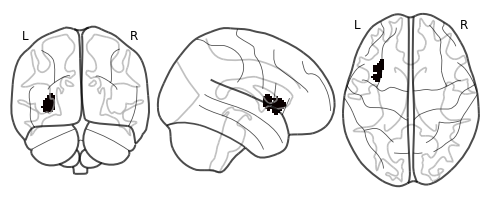

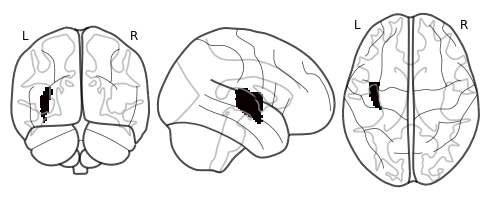

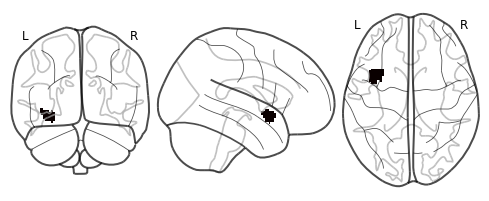

In [9]:
if exists(machine+'/uncon_v_con_lInsula_shock.txt'):
    df = pd.read_csv(machine+'/uncon_v_con_lInsula_shock.txt',sep='\t')
else:
    df = pd.DataFrame(columns=['Subj','ROI','VOX','Y'])
    for indx in [9,11,13]:
    #for indx in [10,12,14]:
        submask = getSubMask(indx,mask)
        print(rois[indx])
        print('Total number of voxels: ',(submask.get_data() == 1).sum())
        plot_glass_brain(submask)
        for ii,row in yoked.iterrows():
            uncon = nil.image.load_img(voxelwise_path.format(subj=row['uncontrol'],
                                                             group='uncontrol'))
            con = nil.image.load_img(voxelwise_path.format(subj=row['control'],
                                                             group='control'))

            uncon_beta = apply_mask(uncon,submask)
            con_beta = apply_mask(con,submask)
            Y = uncon_beta - con_beta
            tmp_df = pd.DataFrame(Y,columns=['Y'],
                                  index=['{name} {k:03d}'.format(name=rois[indx],k=k) for k in range(Y.shape[0])])
            tmp_df.index.name = 'VOX'
            tmp_df.reset_index(inplace=True)
            tmp_df['ROI'] = rois[indx]
            tmp_df['Subj'] = 'P{:02d}'.format(ii)
            df = pd.concat([df,tmp_df],ignore_index=True)
    df.to_csv(machine+'/uncon_v_con_lInsula_shock.txt',sep='\t',index=False)    